# Анализ пользовательского поведения клиентов фитнес-центра: Прогнозирование оттока клиента

## __Описание проекта__

Наша задача разобраться с оттоком клиентов из фитнес-центра. 
Для этого нужно выявить характерные продуктовые метрики, определить какие из них влияют на то, что клиенты либо пользуются услугами центра, либо нет. Проанализировав метрики-характеристики можно будет понять причины оттока клиентов, возможно, даже событий маркеры, т.е. когда это происходит. 

Для проведения анализа нам предаставлен csv-файл с данными о клиентах, которые собрали маркетологи компании.

По результатам нашего анализа должны быть созданы рекомендации, которые помогут маркетологам бороться с оттоком клиентов, и, как следствие, минимизировать финансовые потери фитнес-центра

## __Задачи__

В рамках нашего анализа будут выполнены следующие аналитические задачи:

1) Мы создадим модель, которая будет прогнозировать вероятность ухода каждого конкретного клиента в следующем месяце.

2) Постараемся выделить несколько клиентских кластера и предстваить "портрет" типичного представителя оного.

3) Проанализировать основные индикаторы или маркеры, которые указывают, что клиент близок к уходу.

4) Перечисленные выше задачи должны лечь в основу рекомендаций для маркетологов: что с какими клиентами делать, чтобы они не уходили.



### План работы

1) Загрузим данные, предотсавленные маркетологами, проверим их на пропуски и дубликаты. Если нужно, то преобразуем тип данных.

2) Обработаем полученные данные:

- разобъём пользователей на две группы - кто остался и кто ушёл;

- построим столбчатые гистограммы по признакам для тех, кто ушёл и тех, кто остался;

- посмотрим на корреляцию между признакими. В этом нам поможет матрица корреляций.

3) Создадим модель оттока клиентов: 

- создадим две выборки - тренировочную и контрольную;

- обучим тренировочную выборку методами случайного леса и логистической регрессии;

- оценим метрики accuracy, precision и recall для обоих методов на контрольной выборке.

4) Разделим клиентов на кластеры:

- стандартизируем данные;

- построим матрицу расстояний на стандартизованной матрице признаков и отрисуем дендрограмму;

- применим алгоритм K-means для обучения модели;

- оценим различные признаки в рамках новой кластеризации;

- посторим распределение признаков по кластерам;

- определим долю оттока в каждом кластере.

5) Напишем выводы и рекомендации.

## 1. Предобработка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats as st
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import itertools as itertools
import plotly.express as px

Загрузим исходные данные.

In [2]:
try:
    data = pd.read_csv('/datasets/gym_churn.csv')
except:
    data = pd.read_csv('C:/Users/Пользователь/Downloads/gym_churn.csv')

In [3]:
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Пропусков в данных не видим. 

Проверим данные на дубликаты

In [4]:
data.duplicated().sum()

0

И дубликатов явных не обнаружили.

## 2. Исследовательский анализ данных

Применим к датасету метод describe()

In [5]:
data.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


На первый взгляд по представленным данным можно сделать следующие выводы:

1) Клиенты фитнес-центра - бинарные личности. Но если серьёзно, то непонятно что означают цифры 0 и 1. Предположим ,что "1" соотвествует мужчинам.

2) Подавляющее количество клиентов живёт рядом с нашим фитнес-центром.

3) Почти половина клиентов - это сотрудники компаний-партнёров центра.

4) 30% наших клиентов пришли к нам через друзей и знакомых, за что и получили скидку при подписании договора.

5) У 90% есть телефон.

6) Средняя продолжительность договра  - менее 5 месяцев. Если учесть, что есть триварианта договора - 1, 6 и 12 месяцев - то пока напрашивается вывод о том, что клиенты предпочитают не связывать себя долгими обязательствами. Но, это умозаключение требует проверки.

7) 41% наших клиентов хотя бы раз посещали групповые занятия.

8) Средниий возраст нашего клиента - 29 лет. Что важно - относительно небольшое стандартное отклонение - 3.2 года. Это говорит о том, что подавляющее число наших клиентов - это молодые люди в возрасте 25-35 лет.

9) Сколько зарабатывает центр на доп.услугах - не понятно. Условно - это "149". Но, если учесть, что минимальная сумма равна 0.15, вряд ли клиент купил что-то на 15 копеек. В реальной жизни обратились бы к заказчику за разъяснениями, а пока будем работать так. 

10) В среднем у наших клиентов остаётся еще 4 месяца до завершения договора. Это примечательно, п.ч. средняя продолжительность договора менее 5 месяцев. 

11) Врямя жизни - lifetime - наших клиентов 3.7 месяца. Но! тут очень большая величина стандартного отклонения  - она выше, чем среднее значение. Почему так? Скорее всего, и на это указывают пункты 6 и 10, описанные выше, у нас большой отток клиентов на ранних этапах, но если клиент преодалел опредлённый порог, то он останется лоялен компании. 

11) По средней частоте посещения - по обоим пунктам - примерно одинаковые цифры: чуть менее двух посещений в неделю. В реальности мы бы уточнили время года, за которые предоставленны данные, т.к. услуги фитнес-индустрии имеют сезонность. 

12) Самая главная метрика - отток - свидетельствует, что уходит каждый четвёртый клиент.

Разобьём клиентов по принципу ушёл/остался и посмотрим на признаки.

In [6]:
data.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Можно сделать следующие выводы:

1) Половая составляющая в обеих группах одинаковая. Эта метрика не приоритетная.

2) Среди ушедших чуть выше доля тех, кто живёт не рядом с центром.

3) Что интересно, среди ушедших только одна 1/3 - это сотрудники партнёров. 

4) Только пятая часть от ушедших - пришли к нам по промо-акциям. 

5) Телефон - тут всё понятно.

6) Из тех кто ушёл, средняя продолжительность контракта составляла 1.7 месяца. Т.е. люди отходили потраченные деньги, и сдались...

7) Доля тех, кто посещает грууповые занятия среди ушедших ниже, чем среди лоялистов.

8) Молодежь уходит чаще...у них есть дела поважнее. 

9) Если люди готовы тратится на фитнес и около, то они в меньшей степени уйдут. Доля нецелевых трат среди оставшихся выше, чем по общим данным, а среди ушедших, соответсвенно, ниже. 

10) Для ушедших в среднем время окончания договора составляет чуть более 1.5 месяцев.

11) А "время жизни" - меньше месяца. 

12) Посещения центра 2 раза в неделю минимум для группы лоялистов стабильно. А вот ушедшие ходят всё реже и реже: не чаще полутора раз в неделю, а в последнем месяце только раз в неделю

В реальности мы бы проверили промо-акции и возможность разовых(гостевых, ознакомительных) посещений - на эту мысль наводит маленький лайфтайм ушедших - меньше месяца, хотя по условиям задачи абонементы на 1, 6 и 12 месяцев. 

Отрисуем столбчатые гистограммы. 

<Figure size 360x360 with 0 Axes>

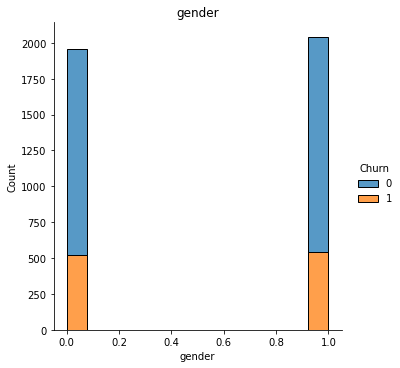

<Figure size 360x360 with 0 Axes>

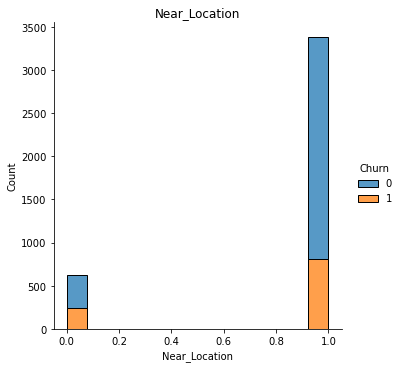

<Figure size 360x360 with 0 Axes>

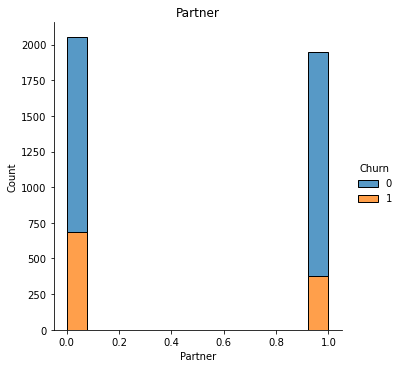

<Figure size 360x360 with 0 Axes>

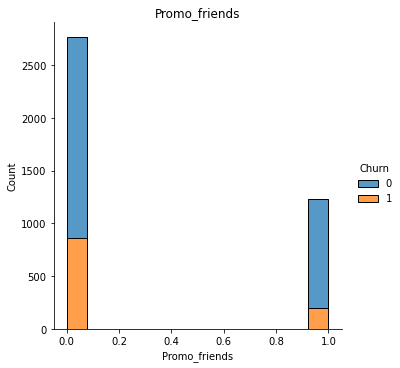

<Figure size 360x360 with 0 Axes>

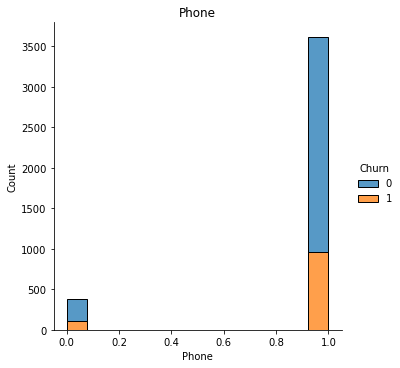

<Figure size 360x360 with 0 Axes>

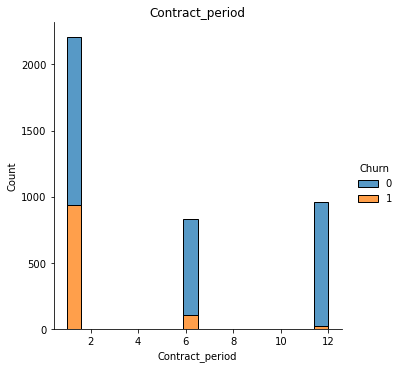

<Figure size 360x360 with 0 Axes>

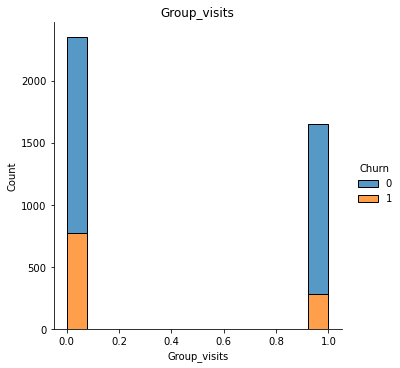

<Figure size 360x360 with 0 Axes>

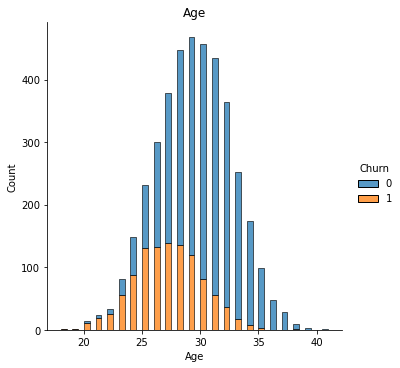

<Figure size 360x360 with 0 Axes>

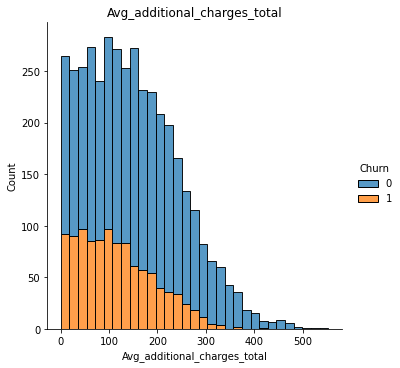

<Figure size 360x360 with 0 Axes>

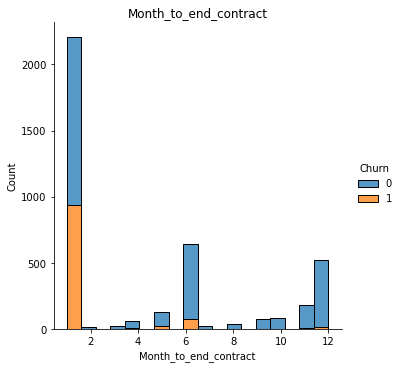

<Figure size 360x360 with 0 Axes>

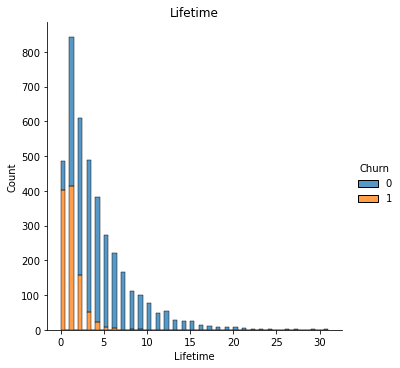

<Figure size 360x360 with 0 Axes>

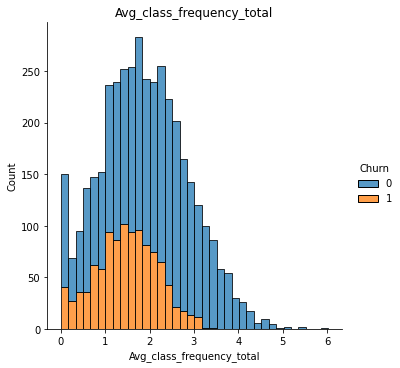

<Figure size 360x360 with 0 Axes>

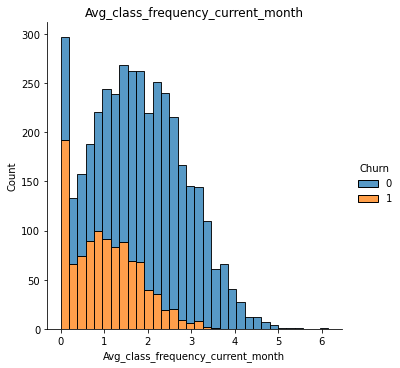

<Figure size 360x360 with 0 Axes>

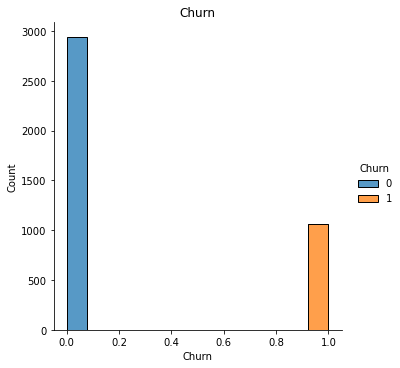

In [7]:
for feature in data.columns:
    plt.figure(figsize=(5, 5))
    sns.displot(data=data, x=data[feature], hue="Churn", multiple="stack")
    plt.title(feature)
    plt.show(); 

Построим корреляционную матрицу.

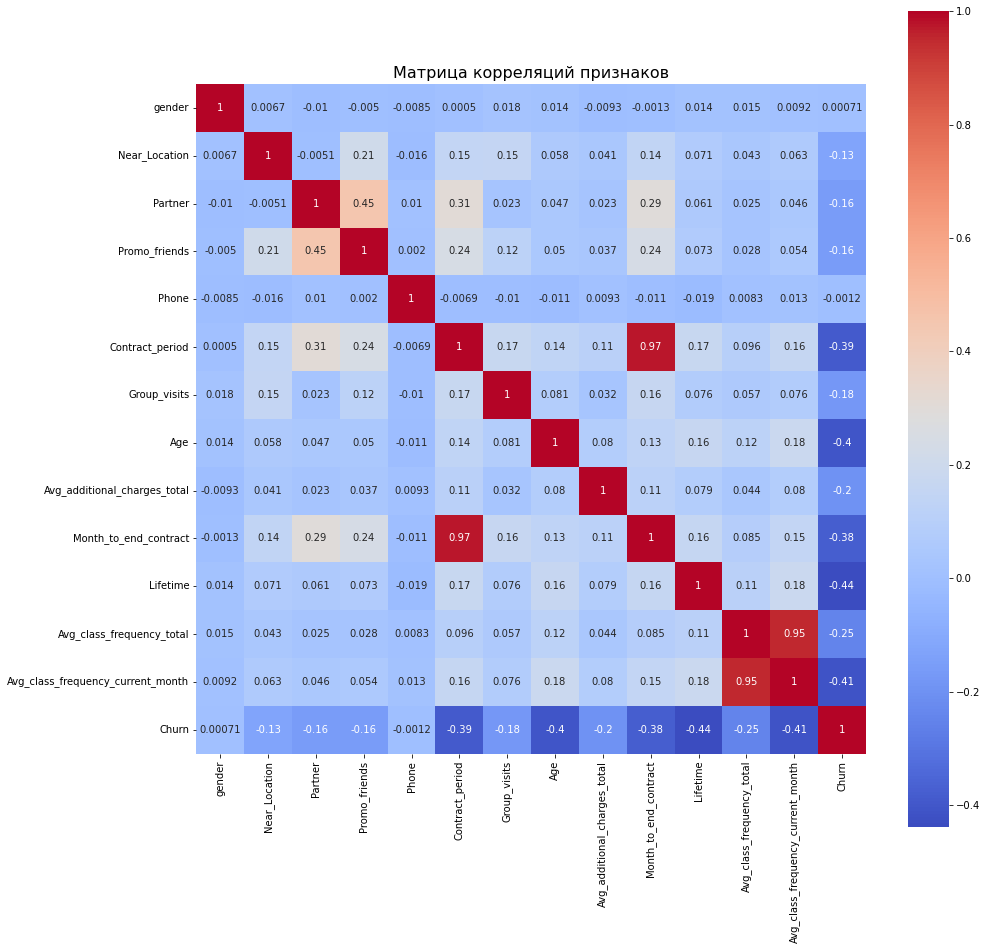

In [8]:
corr_m = data.corr() 

plt.figure(figsize = (15, 15))
sns.heatmap(data=corr_m, square= True, annot = True, cmap='coolwarm') 
plt.title('Матрица корреляций признаков', fontsize=16)
plt.show()

На визуализации видим, что между целевой перемнной - отток (Churn) - и сроком действия текущего договора, возрастом, временем до окончания действующего договора, с моментом первого обращения (lifetime), а также количеством посещений в текущем месяце есть умеренная обратная зависимость. 

Здесь вырисовыввется следующая линия поведения клиента: чем чаще он ходит в зал, тем дольше ему "выхаживать" свой абонемент, чем больше это сила привычки, тем меньше вероятность того, что он уйдёт в отток. Пока эти замечания на уровне очевидных. 

Отдельно отметим возраст. Мы говорили, что наши клиенты - это преимущественно люди 25-35 лет. Так вот чем они старше (естественно в рамках нашей выборки), тем меньше риск того, что они уйдут. 

В корреляционной матрице мы видим несколько признаков с очень высокой зависимостью. При этом, это мультиколлинеарные признаки - с сильной зависимостью друг с другом, но при этом эти признаки дублируют один другой. Это пары признаков Month_to_end_contract и Contract_period; Avg_class_frequency_total и Avg_class_frequency_current_month.  Для того, чтобы наша прогностическая модель работала лучше, мы удалим этим признаки из нашего датасета.

In [9]:
data = data.drop(['Avg_class_frequency_current_month', 'Month_to_end_contract'], axis=1)

## 3. Модель прогнозирования оттока клиентов

Построим модель, которая будет прогнозировать вероятность оттока клиентов. Начнём с алгоритма логистической регрессии. Эта модель нам подходит - у нас всего два класса, для которых мы определяем уйдёт ли коиент или нет.

Разделим наш дата-сет на признаки и целевую переменную (столбец 'Churn' в наших данных).

In [10]:
X = data.drop('Churn', axis = 1)
y = data['Churn']

Создадим две выборки - тренировочну, на которой модель будет учиться, и контрольную, с которой будем сравнивать результат обучения.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Стандартизируем наши данные.

In [12]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)


Зададим алгоритм для модели и обучим её

In [13]:
log_reg_model = LogisticRegression(solver='liblinear', random_state=0)
log_reg_model.fit(X_train_st, y_train)

LogisticRegression(random_state=0, solver='liblinear')

Сделаем прогноз.

In [14]:
log_reg_predictions = log_reg_model.predict(X_test_st)
log_reg_probabilities = log_reg_model.predict_proba(X_test_st)[:,1]

Применив модель оценим три метрики:
Accuracy - отношение правильно спрогназированных обсерваций к их количеству;
Precision - доля обзерваций, названных моделбю положительными, и при этом таковыми являющимися;
Recall - доля положительных обзерваций от существующих, которые нашёл алгоритм.

Но к этим метрикам мы добавим ещё одну метрику ROC-AUC. Если кратко, то это метрика будет показывать на сколько хорошо наш алгоритм классифицирует обзервации. В реальной жизни, если бы мы знали "стоимость" одного клиента, то точно бы понимали, что для нас важнее: потратить ресурсы на удержание клиентов, даже если кто-то всё-таки уйдёт; или съэкономить, но бороться только за "100%" кейсы. Вот для этого нам и нужна эта метрика.  

Эти метрики для этого алгоритма и следующего (RandomForest) станут основанием для выбора модели. 

In [15]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, log_reg_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, log_reg_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, log_reg_predictions)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, log_reg_probabilities)))

Accuracy: 0.91
Precision: 0.83
Recall: 0.83
ROC_AUC: 0.96


Всё тоже самое выполним для алгоритма случайного леса.

In [16]:
ran_for_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
ran_for_model.fit(X_train_st, y_train)
ran_for_predictions = ran_for_model.predict(X_test_st) 
ran_for_probabilities = ran_for_model.predict_proba(X_test_st)[:,1]

In [17]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, ran_for_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, ran_for_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, ran_for_predictions)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, ran_for_probabilities)))

Accuracy: 0.89
Precision: 0.81
Recall: 0.79
ROC_AUC: 0.95


В целом оба алгоритма показали хорошие прогностические возможности. Но, алгоритм логистической регрессии "победил" по всем критериям. Будем использовать его. 

В последующем нашей моделе можно будет "скармливать" данные и, применяя методы predict и prredict_proba, определять уйдёт ли клиент и с какой вероятностью (вероятность опеределения к классу). 

## 4. Кластеризация клиентов

Стандартизируем наши данные, положим в таблицу и сделаем "линк", который используем при создании древовидной схемы. Это будет визуализация нашей иерархической кластеризации.

In [18]:
data_standard = StandardScaler().fit_transform(X)

linked = linkage(data_standard, method = 'ward') 

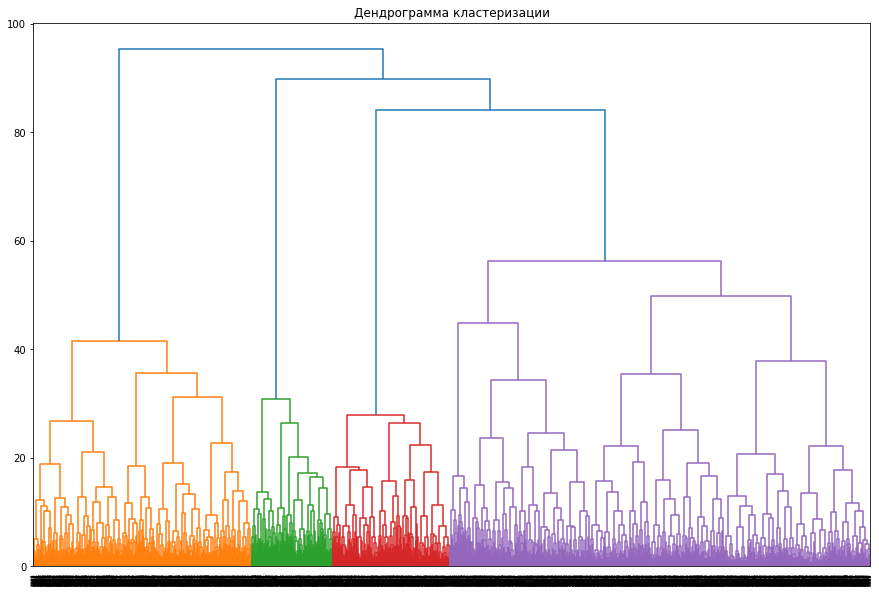

In [19]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма кластеризации')
plt.show() 

Наша дендрограмма позволяет нам выделить 4-5 классов. Остановимся на большем числе. 

Применим метод K-Means и посмотрим на средние значения признаков для кластеров.

In [20]:
k_means = KMeans(n_clusters=5, random_state=0)
labels = k_means.fit_predict(data_standard)
data['cluster'] = labels
print(data.groupby('cluster').mean())

           gender  Near_Location   Partner  Promo_friends  Phone  \
cluster                                                            
0        0.499109       0.000000  0.488414       0.076649    1.0   
1        0.488571       0.995238  0.955238       0.892381    1.0   
2        0.505300       1.000000  0.238516       0.059187    1.0   
3        0.544202       1.000000  0.250287       0.079219    1.0   
4        0.523316       0.862694  0.471503       0.305699    0.0   

         Contract_period  Group_visits        Age  \
cluster                                             
0               3.032086      0.235294  28.721925   
1               7.660952      0.458095  29.543810   
2               2.819788      0.000000  28.770318   
3               4.528129      1.000000  29.536165   
4               4.777202      0.427461  29.297927   

         Avg_additional_charges_total  Lifetime  Avg_class_frequency_total  \
cluster                                                                  

Что получаем: 

Кластеры можно разделить на три условные группы по количеству оттока: низкий (кластер 1), средний (кластреа 3 и 4), высокий (кластера 0 и 2).

В нулевом кластере, где самый высокйи уровень оттока (40%), все клиенты живут не рядом с залом, не попали под действие промо-акций. Почти половина представителей кластера - сотрудники фирм партнёров. 

В первом кластере, где самый низкий уровень оттока (12%), Почти все клиенты живут рядом с фитнес-центром, но, что важно на наш взгляд имеют две сильных привязки (на уровне близким к 100%): это сотрудники фирм-партнёров и участники промо-акций. 

Во втором кластере, где также очень высокий отток нулевой уровень посещения групповых занятий. 

In [21]:
data['cluster'].value_counts()

2    1132
1    1050
3     871
0     561
4     386
Name: cluster, dtype: int64

На "лояльные" кластеры приходится 57.5% всей аудитории. 

Визуализируем распределение характеристик клиентов для каждого кластера. Но, сделаем это отдельно для характеристик принимающих только двойственные значения и только множественные.

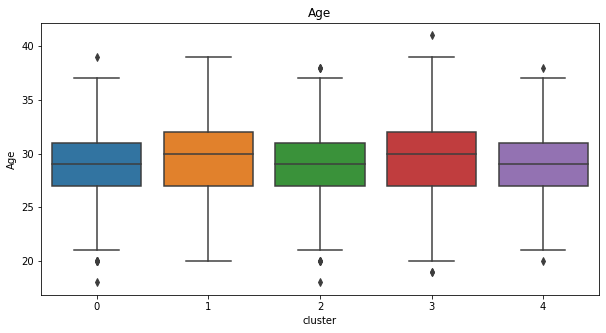

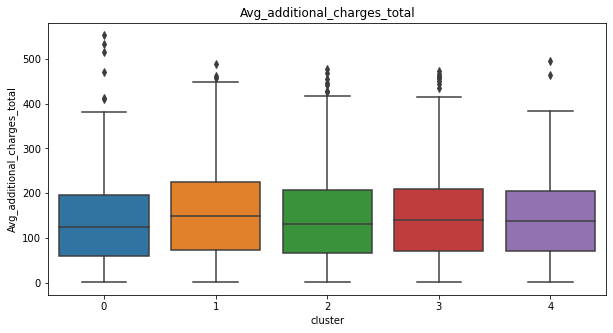

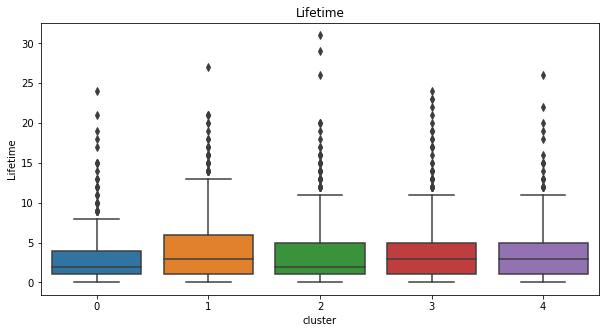

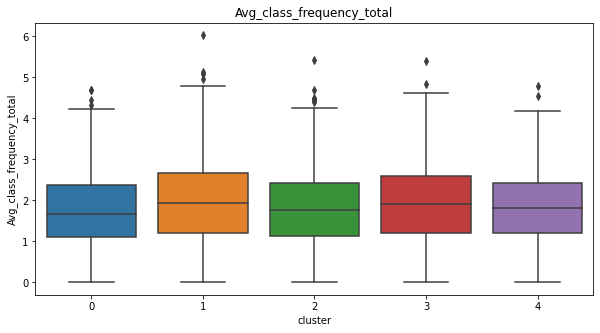

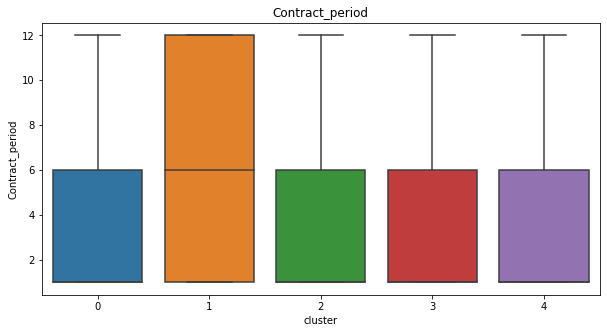

In [22]:
for feature in ['Age', 'Avg_additional_charges_total', 'Lifetime', 'Avg_class_frequency_total', 'Contract_period']:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x = 'cluster', y=feature, data=data)
    plt.title(feature)
    plt.show();

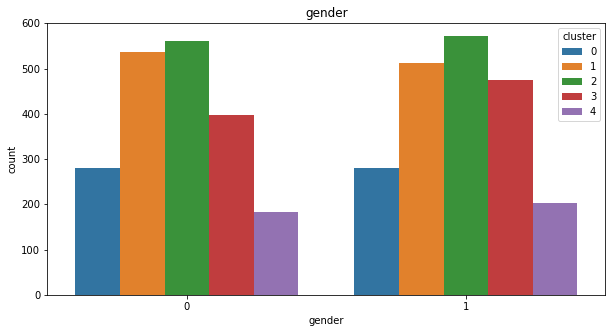

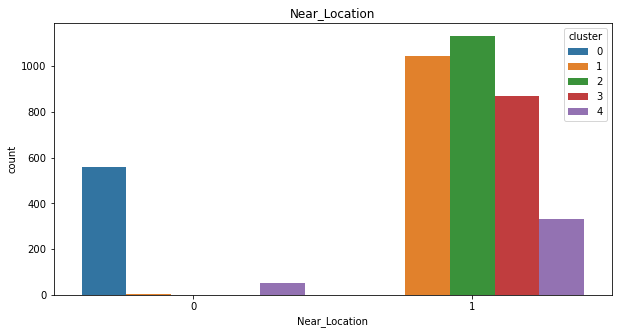

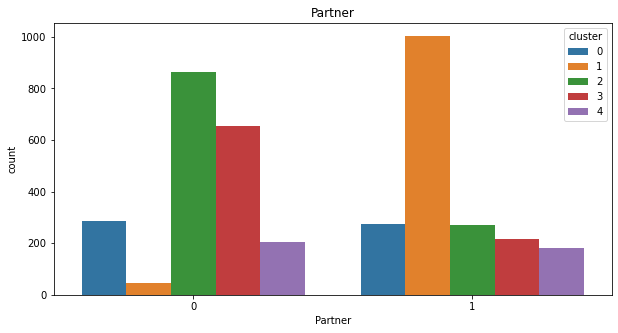

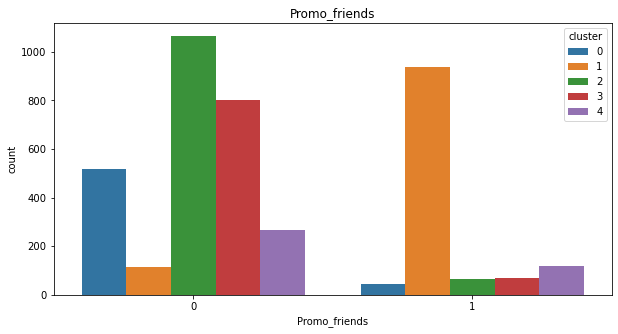

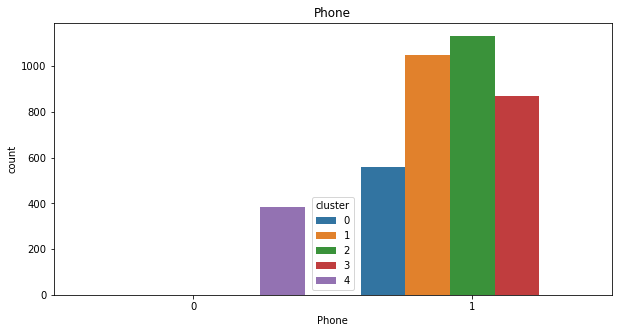

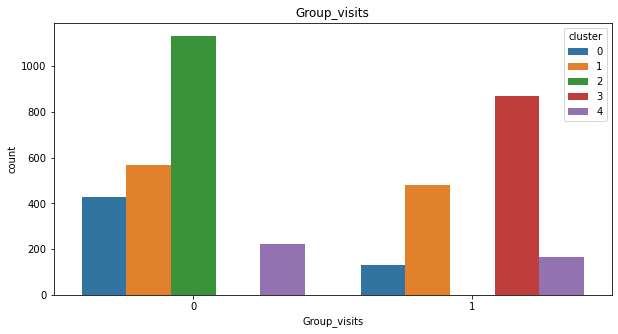

In [23]:
for feature in ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits']:
    plt.figure(figsize=(10, 5))
    sns.countplot(x = feature, hue='cluster', data=data)
    plt.title(feature)
    plt.show(); 

In [24]:
data.groupby('cluster').agg({'Churn':'mean'}).sort_values(by='Churn', ascending=False)

,Churn
cluster,
0,0.399287
2,0.381625
4,0.266839
3,0.200918
1,0.120952


### Портрет клиента по кластерам

На основании всей информации можно составить портрет "типичного" представителя каждого кластера.

__Нулевой кластер. "Путешественник"__

28 лет. В зале появляется 1,7 раза в неделю, потому что живёт не рядом с залом. На групповые занятия ходит редко (один из четырёх).  В основном, это представитель фирмы-партнёра, с промо-акциями не знаком. Имеет достаточно "короткий" договор. Из этого кластера отток составляет без малого 40%. 

__Первый кластер. "Сотрудник фирмы_партнёра"__

29 лет. Живёт рядом. Сотрудник фирмы-партнёра. Ходит часто - около 2-х раз в неделю. Имеет длительный договор. Тратится на "околофитнес". Это убеждённый сторонник фитнеса. Вероятность оттока 12% - только елси найдёт специализированный зал или переедет.

__Второй кластер. "Пришёл попробовать"__

28 лет. Живёт рядом. Про промо-акции ничего не слышал. Но может иметь отношение к партнёрским фирмам. Ходит чуть чаще 1,5 раз в неделю. Групповые занятия избегает. Старается в зале ничего не покупать. Отток почти 40%.

__Третий кластер. "Групповик"__

29 лет. Живёт рядом. Отношения к партнёрам имеет редко. С промо-акциями не знаком. Посещает зал чуть реже двух раз в неделю. Его главная цель - это групповые занятия. Отток около 20%.

__Четвёртый кластер. "Среднячек"__

29 лет. Живёт рядом. Работает в фирме партнёре с вероятностью близкой 1 к 2. В зал ходит почти два раза в неделю. Но имеет достаточно длительный период жизни. Тратится на доп.услуги нечасто. В отток уходит каждый четвёртый. 

## 5. Выводы и рекомендации.

Мы провели следующие работы.

1) Загрузили данные и предобработали данные.

2) Провели анализ данных:

- разобили пользователей на две группы - кто остался и кто ушёл;

- построили столбчатые гистограммы по признакам для тех, кто ушёл и тех, кто остался;

- посмотрили на корреляцию между признакими.

Отток среди сотрудников фирм-партнёров и участников промо-акций низкий. 

Среди тех, кто ходит меньше одного раза в неделю высокий уровень оттока. И наоборот, если клиент ходит три и более раз в недлю, то доля оттока будет очень низкой.

В течение первых двух месяцев клиент решает для себя будет он ходить или нет. Отток в этот период наибольший. Если отметка в два месяца (Lifetime) пройдена и клиент не бросил, то следующем рубежем будет отметка в  6 месяцев. Потом доля оттока становится достаточно низкой. 

3) Создадли модель оттока клиентов: 

- создадили две выборки - тренировочную и контрольную;

- обучили тренировочную выборку методами случайного леса и логистической регрессии;

- оценили метрики accuracy, precision и recall для обоих методов на контрольной выборке;

- также добавили метрику ROC-AUC;

В целом оба алгоритма показали хорошие прогностические возможности.Но, алгоритм логистической регрессии "победил" по всем критериям. Будем использовать его. 


4) Разделили клиентов на кластеры:

- стандартизировали данные;

- построили матрицу расстояний на стандартизованной матрице признаков и отрисовали дендрограмму;

- применили алгоритм K-means для обучения модели;

- оценили различные признаки в рамках новой кластеризации. Теперь она состоит из пяти кластеров;

- посторили распределение признаков по кластерам;

- определили долю оттока в каждом кластере;

- нарисовали потрет "типичного" представителя каждого кластера.

### Рекомендации

Строго говоря, у нас может быть три стратегии решения проблеммы оттока: 

- Понять, почему люди уходят и решить их "проблемы";

- Или понять, почему клиенты ходят и "усилить" влияние положительных черт на других клиентов;

- и наконец - соединить первую и вторую стратегии. 

Есть характеристики, на которые мы повляить не можем. Например, высокий отток в нулевом кластере - это результат того, что они живут далеко от фитнес-центра. "Заманить" их нам будет сложно. 

Однако есть вполне посильные задачи.

1) Есть два очень похожих кластера второй и третий. Они отличаются оттоком (для второго он в два раза выше) и уровнем посещения групповых занятий (100% в третьем и ноль во втором). Остальные метрики очень схожи. Наша задача "затащить" предстваителей второго кластера на групповые занятия.

2) Низкий отток в первом кластере - это сотрудники фирм-партнёров, попавших под действия акций. Отсюда два следствия: а) расширяем количество партнёров-участников; б) увеличиваем охват промо-акций, в первую очередь, на кластеры с высоким оттоком. Но! нужно смотреть на сколько такие"широкие жесты" экономически оправданы. Из исслдеования нам неизвестна средняя стоимость клиента и профит с него.

3) Наши действия должны быть ориентированы на заключение длительных договоров с клиентами. Чем больше срок договора, тем выше желание его отходить. А там уже включается сила привычки. Клиенты часто уходят в отток после 1 или двух месяцев, при этом они имеют маленький лайф-тайм. От коротких договоров лучше отказаться. Приоритетными являются контракты на 12 месяцев (даже не на 6!) 

Наша главная цель, чтобы живущий рядо потенциальный клиент, который "пришёл попробовать", остался в зале. Поэтому описанные выше положения должны быть преимущественно направлены на представителей третьего кластера, чтобы мы их по-тихоньку трансформировали в четвёртый.